# Simple Retrieval Augmented Generation (RAG) with Memory

Extends Simple RAG by maintaining context from previous interactions

**When to use:** Conversational AI where continuity between queries is important

Author: [Manoj Jahgirdar](https://www.linkedin.com/in/manojjahgirdar)

## Retrieval-Augmented Generation (RAG) Pipeline

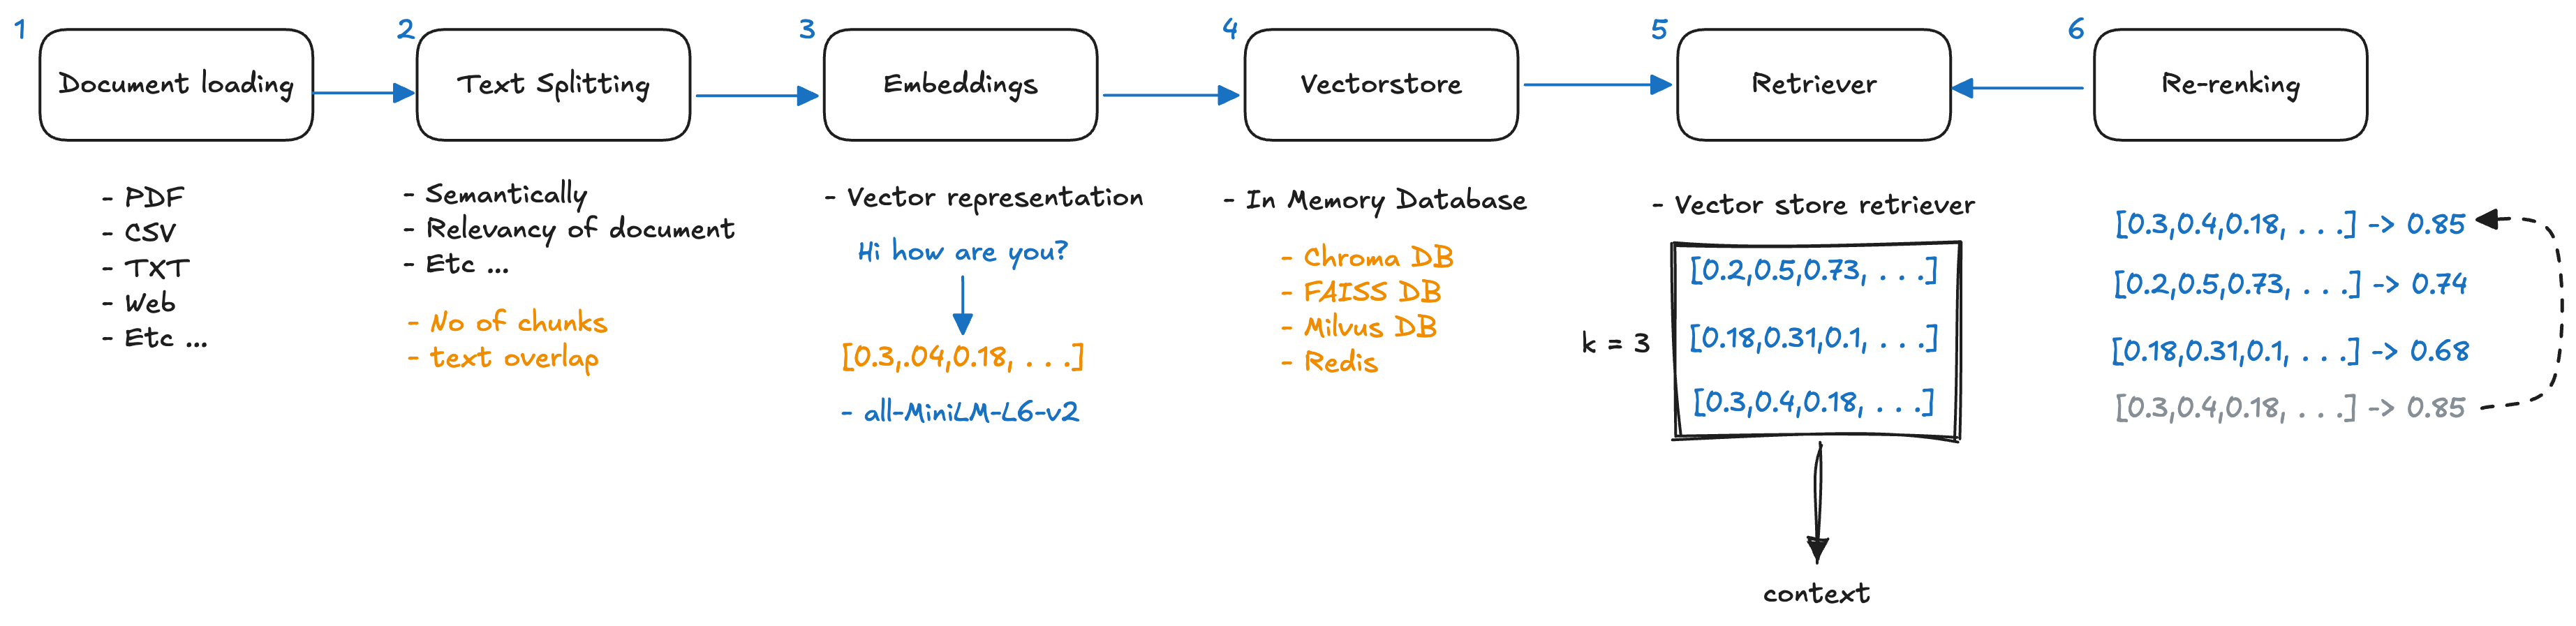

## Install dependencies

In [1]:
%pip install --quiet --upgrade sentence-transformers faiss-cpu rank_llm pymupdf
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph langchain-chroma langchain_openai langchain-huggingface

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Export environment variables

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "rag-techniques"

## Step 1: Document Loading

In [4]:
from langchain_community.document_loaders import PyMuPDFLoader

In [5]:
file_path = "documents/formula1-technical-regulations.pdf"
loader = PyMuPDFLoader(file_path)
docs = loader.load()
print(f"{len(docs)} Pages loaded")

179 Pages loaded


## Step 2: Text splitting

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [7]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)
print(f"{len(docs)} Pages split into '{len(all_splits)}' chunks")

179 Pages split into '682' chunks


## Step 3: Embeddings

In [8]:
from langchain_huggingface import HuggingFaceEmbeddings

In [9]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

## Step 4: Define Vectorstore

In [10]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="formula-one",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [11]:
_ = vector_store.add_documents(documents=all_splits)

## Step 5: Retriever

In [12]:
# Helper function for printing docs
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i + 1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

In [13]:
retrieved_docs = vector_store.similarity_search("What are the Aerodynamic Components of the formula one car?", k=3)
docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
# pretty_print_docs(retrieved_docs)

## Step 6: Re-ranking

In [14]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_community.document_compressors.rankllm_rerank import RankLLMRerank

In [15]:
retriever = vector_store.from_documents(all_splits, embeddings).as_retriever(search_kwargs={"k": 4})

In [16]:
query = "What are the Aerodynamic Components of the formula one car?"
docs = retriever.invoke(query)
# pretty_print_docs(docs)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [17]:
import torch
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_community.document_compressors.rankllm_rerank import RankLLMRerank

torch.cuda.empty_cache()

compressor = RankLLMRerank(top_n=3, model="gpt", gpt_model="gpt-4o-mini")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

del compressor

In [ ]:
compressed_docs = compression_retriever.invoke(query)
pretty_print_docs(compressed_docs)

## Define Large Language Model (LLM)

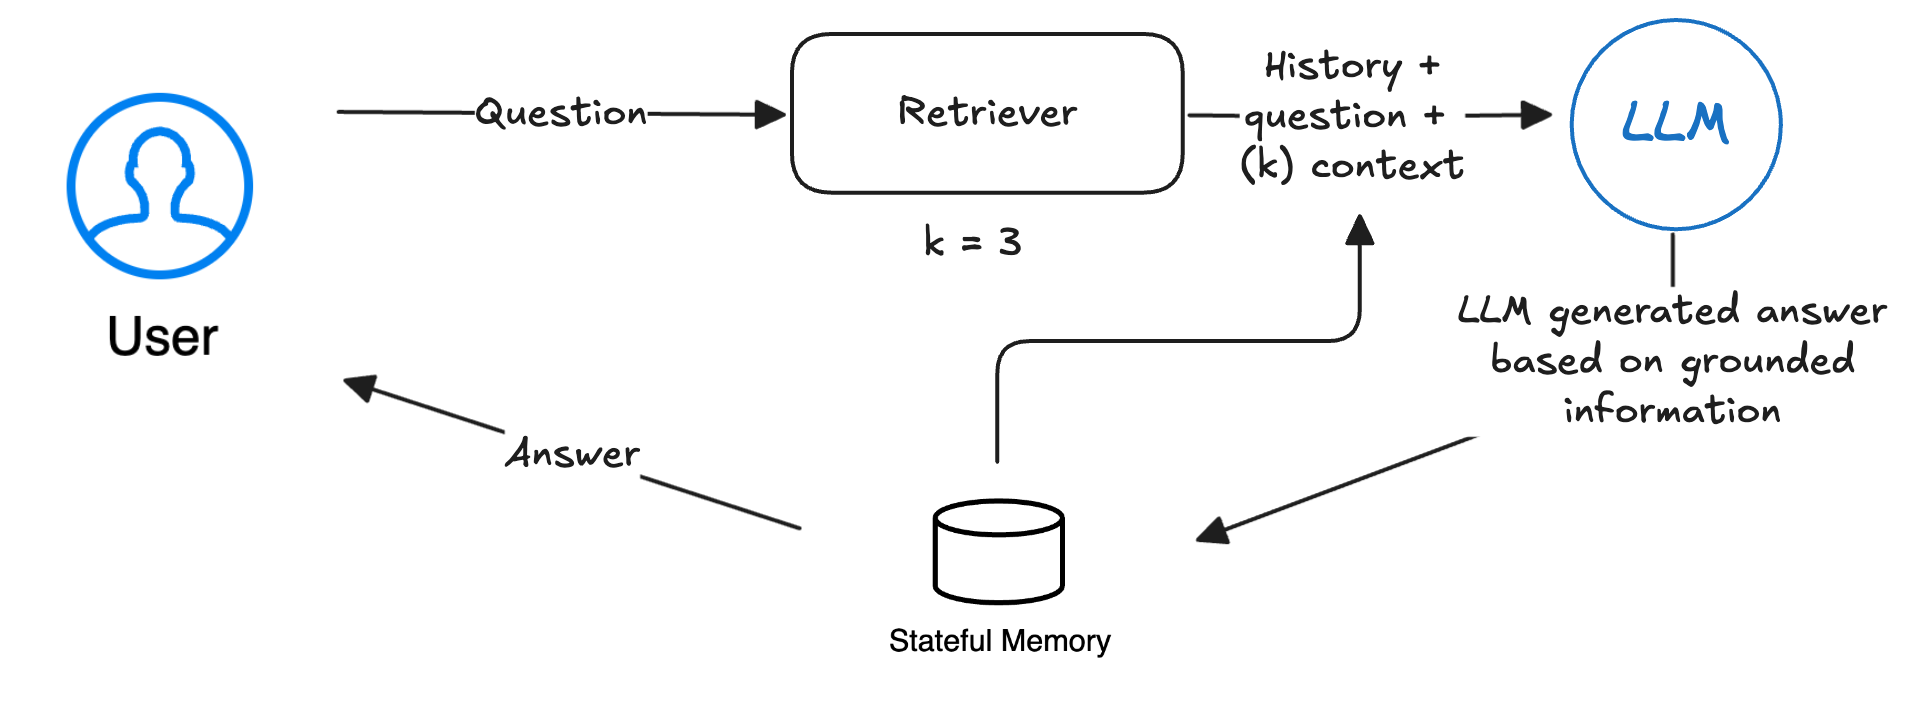

In [18]:
import getpass
import os
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

## Define Graph with LangGraph

In [19]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [20]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=3)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [21]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [22]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

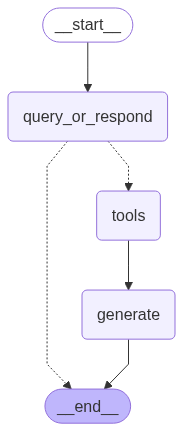

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "id-1"}}

In [25]:
input_message = "What are the Aerodynamic Components of the formula one car?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What are the Aerodynamic Components of the formula one car?


2025-07-13 16:35:55,278 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  retrieve (call_osoXEiQPQYUlM1t5y4ojFnSf)
 Call ID: call_osoXEiQPQYUlM1t5y4ojFnSf
  Args:
    query: Aerodynamic components of Formula One car
================================= Tool Message =================================
Name: retrieve

Source: {'author': '', 'keywords': '', 'total_pages': 179, 'moddate': '2025-02-26T11:59:04+01:00', 'title': '', 'modDate': "D:20250226115904+01'00'", 'source': 'documents/formula1-technical-regulations.pdf', 'subject': '', 'creator': 'Microsoft® Word for Microsoft 365', 'creationdate': '2025-02-26T11:59:04+01:00', 'page': 1, 'trapped': '', 'format': 'PDF 1.7', 'producer': 'Microsoft® Word for Microsoft 365', 'file_path': 'documents/formula1-technical-regulations.pdf', 'creationDate': "D:20250226115904+01'00'"}
Content: 2025 Formula 1 Technical Regulations 
2 
26 February 2025 
© 2025 Fédération Internationale de l’Automobile 
 
Issue 2 
 
3.10 
Rear Wing 
3.

2025-07-13 16:35:57,568 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Aerodynamic components of a Formula One car include all parts that contact the external air stream, such as wings, bodywork, and ducts for cooling. Specific components listed in Article 3 of the regulations include inlet or outlet ducts for cooling, air boxes for the power unit, and primary heat exchangers. However, items not considered part of the bodywork include cameras, rear view mirrors, and parts related to the mechanical functioning of the power train.


In [26]:
input_message = "Can you tell me which articles refer to it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you tell me which articles refer to it?


2025-07-13 16:36:00,241 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

The articles that refer to aerodynamic components in the Formula One Technical Regulations include:

- **Article 3: Aerodynamic Components**
  - 3.1 Definitions of Aerodynamic Components or Bodywork
  - 3.10 Rear Wing
  - 3.12 Bodywork not defined in Articles 3.5 to 3.11
  - 3.13 Wheel bodywork
  - 3.14 Suspension Fairings
  - 3.15 Aerodynamic Component Flexibility
  - 3.16 Aerodynamic Component construction

These articles detail various aspects of aerodynamic components, including their definitions, specifications, and regulations regarding their construction and functionality.


---